# Vegetation Phenology <img align="right" src="../Supplementary_data/DE_Africa_Logo_Stacked_RGB_small.jpg">

* **Products used:** 
[ls8_usgs_sr_scene](https://explorer.digitalearth.africa/ls8_usgs_sr_scene)


## Background
Phenology is the study of how plant and animal life cycles in the context of the seasons.
It can be useful in understanding the life cycle trends of crops, and how the growing seasons are affected by changes in climate.
For more information, see the [USGS page on phenology](https://www.usgs.gov/land-resources/eros/phenology).

## Description

This notebook calculates vegetation phenology changes using Landsat 8 data.
To detect changes in plant life for Landsat, the algorithm uses either the Normalized Difference Vegetation Index (NDVI) or the Enhanced Vegetation Index (EVI), which are common proxies for vegetation growth and health.
The outputs of this notebook can be used to assess differences in agriculture fields over time or space and also allow the assessment of growing states such as planting and harvesting.
This notebook demonstrates the following steps:

1. First we do this
2. Then we do this
3. Finally we do this

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Load key Python packages and supporting functions for the analysis.

In [1]:
%matplotlib inline

import datacube
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import xarray as xr
import datetime as dt
import os

sys.path.append('../Scripts')
from deafrica_datahandling import load_ard, mostcommon_crs
from deafrica_bandindices import calculate_indices
from deafrica_plotting import display_map


from plotter_utils import xarray_time_series_plot
from phenology import TIMESAT_stats

import warnings
warnings.filterwarnings("ignore", "Mean of empty slice")
warnings.simplefilter("ignore", FutureWarning)

### Connect to the datacube

Connect to the datacube so we can access DE Africa data.
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [2]:
dc = datacube.Datacube(app='Vegetation_phenology')

### Analysis parameters

The following cell sets important parameters for the analysis:

* `veg_proxy`: Band index to use as a proxy for vegetation health e.g. `NDVI` or `EVI`
* `latitude`: The latitude range of your Area of Interest box e.g. `(-10.6999, -10.6959)`
* `longitude`: The longitude range of your Area of Interest box e.g. `(35.2608, 35.2662)`


In [3]:
veg_proxy = 'NDVI'

# Aviv Coffee Farm, Tanzania (small)
latitude = -10.6996
longitude = 35.2708
buffer = 0.004

years_range = ('2013', '2018')

## View the selected location
The next cell will display the selected area on an interactive map.
Feel free to zoom in and out to get a better understanding of the area you'll be analysing.
Clicking on any point of the map will reveal the latitude and longitude coordinates of that point.

In [4]:
x = (longitude-buffer, longitude+buffer)
y = (latitude+buffer, latitude-buffer)

In [5]:
display_map(x=x, y=y)

## Load cloud-masked Landsat data

The `load_ard` function gives us Analysis-Ready data that has been masked for cloud, shadow and quality filters.

In [6]:
query = {
    'y': y,
    'x': x,
    'time': years_range,
    'measurements': ['red', 'blue', 'nir'],
    'resolution': (-30,30),
}

crs = mostcommon_crs(dc=dc,
                     product='ls8_usgs_sr_scene',
                     query=query
                    )
    
dataset = load_ard(dc=dc,
                   products=['ls8_usgs_sr_scene'],
                   output_crs=crs,
                   **query
                  )

Using pixel quality parameters for USGS Collection 1
Finding datasets
    ls8_usgs_sr_scene
Applying pixel quality/cloud mask
Loading 221 time steps


**Once the load is complete**, examine the data by printing it in the next cell.
The `Dimensions` argument revels the number of time steps in the data set, as well as the number of pixels in the `x` (longitude) and `y` (latitude) dimensions.

In [7]:
dataset

<xarray.Dataset>
Dimensions:  (time: 221, x: 30, y: 30)
Coordinates:
  * time     (time) datetime64[ns] 2013-04-21T07:47:21.977564 ... 2018-12-31T07:45:27.105157
  * x        (x) float64 7.479e+05 7.48e+05 7.48e+05 ... 7.488e+05 7.488e+05
  * y        (y) float64 -1.183e+06 -1.183e+06 ... -1.184e+06 -1.184e+06
Data variables:
    red      (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    blue     (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    nir      (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    crs:      epsg:32636

## Compute band indices

The Nomalized Difference Vegetation Index (NDVI) requires the `red` and `nir` (near-infra red) bands.

$$
\begin{aligned}
\text{NDVI} & = \frac{(\text{NIR} - \text{Red})}{(\text{NIR} + \text{Red})} \\
\end{aligned}
$$

The Enhanced Vegetation Index requires `red`, `nir` and `blue`.

$$
\begin{aligned}
\text{NDVI} & = \frac{2.5 \times (\text{NIR} - \text{Red})}{(\text{NIR} + 6 \times \text{Red} - 7.5 \times \text{Blue} + 1)} \\
\end{aligned}
$$

In [8]:
dataset = calculate_indices(dataset, index=veg_proxy, collection='c1')
dataset

<xarray.Dataset>
Dimensions:  (time: 221, x: 30, y: 30)
Coordinates:
  * time     (time) datetime64[ns] 2013-04-21T07:47:21.977564 ... 2018-12-31T07:45:27.105157
  * x        (x) float64 7.479e+05 7.48e+05 7.48e+05 ... 7.488e+05 7.488e+05
  * y        (y) float64 -1.183e+06 -1.183e+06 ... -1.184e+06 -1.184e+06
Data variables:
    red      (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    blue     (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    nir      (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    NDVI     (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    crs:      epsg:32636

## Create phenology products

### Plot the Vegetation Index Over Time in a Box-and-Whisker Plot

Set the parameters for the plot:

* `plot_curve_fit`: Specify whether to plot a curve fit of the vegetation index along time, either `True` or `False`.
* `curve_fit_target`: Specify the target aggregation type of the curve fit, either `'mean'` or `'median'`
* `max_times_per_plot`: Set the maximum number of data points that appear along time in each plot. If more than this number of data points need to be plotted, a grid of plots will be created.
* `bin_by`: Select the binning approach for the vegetation index:
  *  `None` do not bin the data
  * `'week'` bin the data by week with an extended time axis
  * `'month'` bin the data by month with an extended time axis
  * `'weekofyear'` bin the data by week and years using a single year time axis
  * `'monthofyear'` bin the data by month and years using a single year time axis

In [9]:
plot_curve_fit = True

curve_fit_target = 'median'

max_times_per_plot = 40 

bin_by = 'monthofyear'

#### Generate the plot

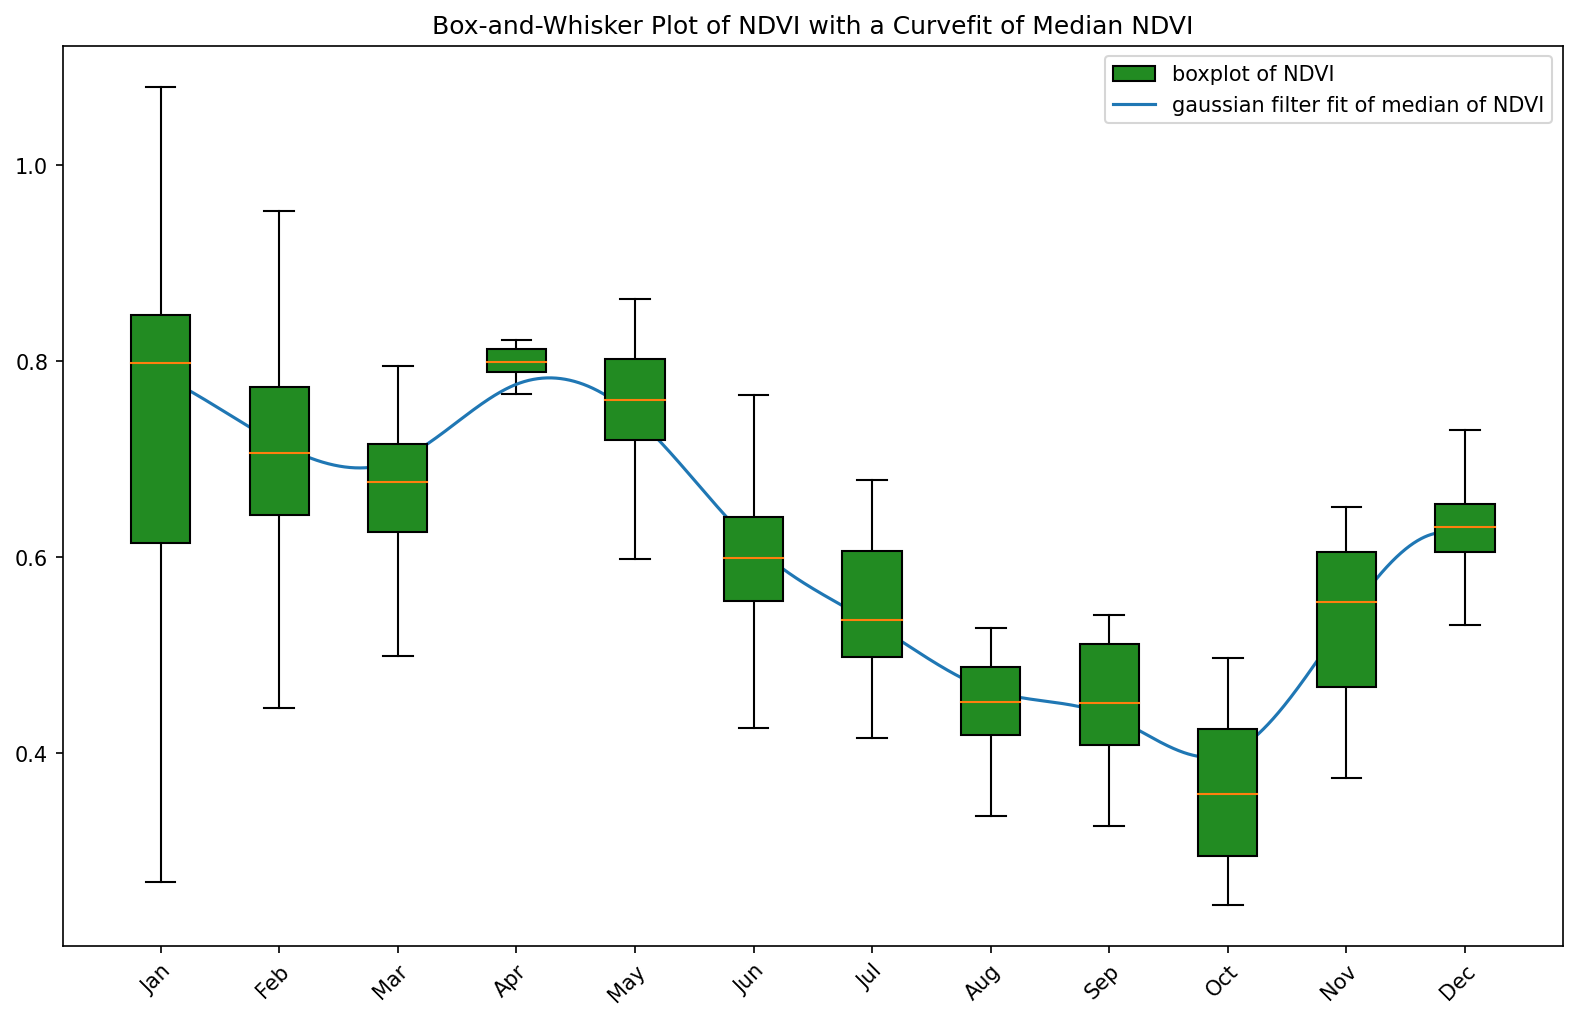

In [10]:
aggregated_by_str = None
if bin_by is None:
    plotting_data = dataset
elif bin_by == 'week':
    plotting_data = dataset.resample(time='1w').mean(skipna=True)
    aggregated_by_str = 'Week'
elif bin_by == 'month':
    plotting_data = dataset.resample(time='1m').mean(skipna=True)
    aggregated_by_str = 'Month'
elif bin_by == 'weekofyear':
    plotting_data = dataset.groupby('time.week').mean(dim=('time'), skipna=True)
    aggregated_by_str = 'Week of Year'
elif bin_by == 'monthofyear':
    plotting_data = dataset.groupby('time.month').mean(dim=('time'), skipna=True)
    aggregated_by_str = 'Month of Year'
else:
    assert bin_by in [None, 'week', 'month', 'weekofyear', 'monthofyear'], \
        "The variable 'bin_by' can only have one of these values: "\
        "[None, 'week', 'month', 'weekofyear', 'monthofyear']"

plot_descs = {veg_proxy: {'none': [{'box': {'boxprops': {'facecolor':'forestgreen'}}}]}}
if plot_curve_fit:
    plot_descs[veg_proxy][curve_fit_target] = [{'gaussian_filter':{}}]

xarray_time_series_plot(
    dataset=plotting_data,
    plot_descs=plot_descs,
    x_coord='x', y_coord='y',
    fig_params=dict(figsize=(10,6), dpi=150),
    max_times_per_plot=max_times_per_plot
)

plt.title(f'Box-and-Whisker Plot of {veg_proxy} with a Curvefit of Median {veg_proxy}')
plt.show()

### Plot the Vegetation Index Over Time for Each Year

* `bin_by`: Select the binning approach for the vegetation index:

 * `'weekofyear'` bin the data by week and years using a single year time axis
 * `'monthofyear'` bin the data by month and years using a single year time axis

In [11]:
bin_by = 'monthofyear'

In [12]:
years_with_data = []
plot_descs = {}
daysofyear_per_year = {}
plotting_data_years = {}
time_dim_name = None

for year in np.unique(dataset.time.dt.year):
    year_data = dataset.sel(time=str(year))[veg_proxy]
    if len(year_data['time']) == 0: # There is nothing to plot for this year.
        print("Year {} has no data, so will not be plotted.".format(year))
        continue
    years_with_data.append(year)
    
    spec_ind_dayofyear = year_data.groupby('time.dayofyear').mean()
    daysofyear_per_year[year] = spec_ind_dayofyear.where(~spec_ind_dayofyear.isnull()).dayofyear

    aggregated_by_str = None
    if bin_by == 'weekofyear':
        plotting_data_year = year_data.groupby('time.week').mean(dim=('time'))
        time_dim_name = 'week'
    elif bin_by == 'monthofyear':
        plotting_data_year = year_data.groupby('time.month').mean(dim=('time'))
        time_dim_name = 'month'
    else:
        assert bin_by in ['weekofyear', 'monthofyear'], \
            "The variable 'bin_by' can only have one of these values: "\
            "['weekofyear', 'monthofyear']"            

    plotting_data_years[year] = plotting_data_year  
    plot_descs[year] = {'mean':[{'gaussian_filter':{}}]}

plotting_data = xr.merge([{k:v} for k,v in plotting_data_years.items()])

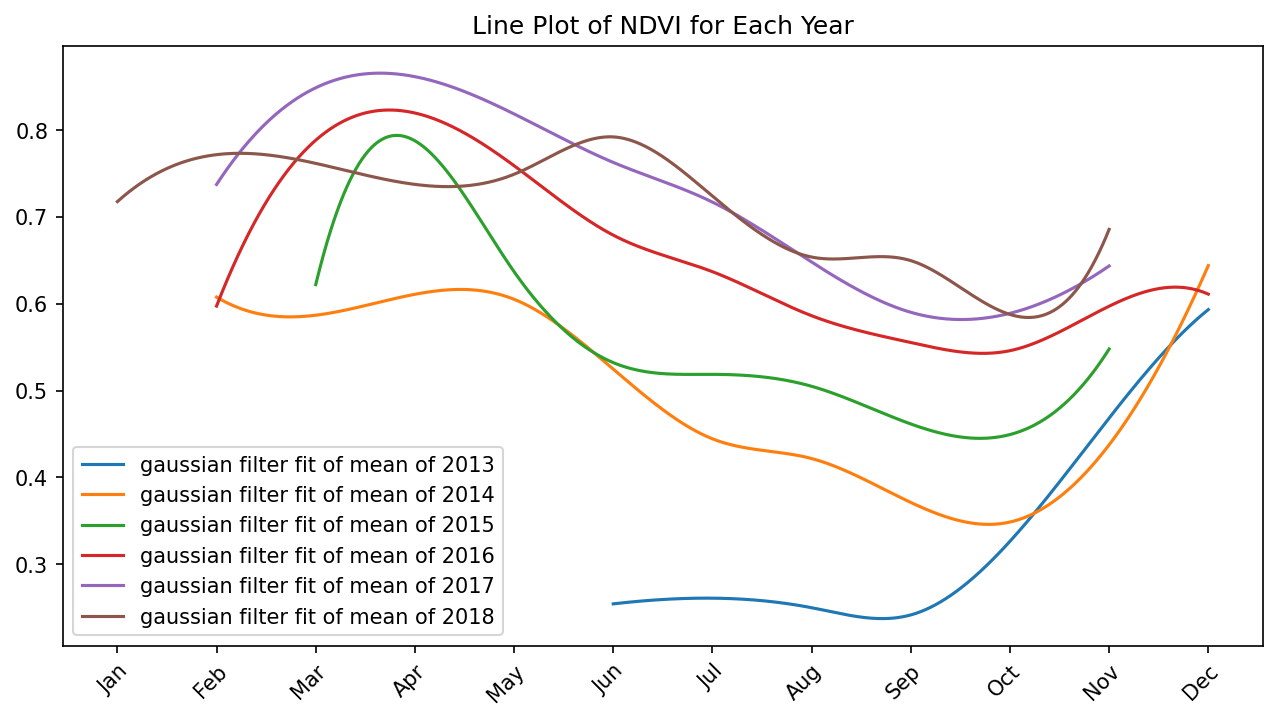

In [13]:
fig, curve_fit_plotting_data = xarray_time_series_plot(
    dataset=plotting_data, 
    plot_descs=plot_descs, 
    x_coord='x', y_coord='y',
    fig_params=dict(figsize=(8,4), dpi=150)
)
plt.title(f'Line Plot of {veg_proxy} for Each Year')
plt.show()

### Export Curve Fits to a CSV File

In [14]:
# Convert the data to a `pandas.DataFrame`.
dataarrays = []
for (year, _, _), dataarray in curve_fit_plotting_data.items():
    dataarrays.append(dataarray.rename(year))
curve_fit_df = xr.merge(dataarrays).to_dataframe()

In [15]:
# Convert the month floats to day ints and average by day (scale to [0,1], multiply by 364, add 1).
curve_fit_df.index.values[:] = (364/11) * (curve_fit_df.index.values - 1) + 1
curve_fit_df.index = curve_fit_df.index.astype(int)
curve_fit_df.index.name = 'day of year'
curve_fit_df = curve_fit_df.groupby('day of year').mean()

In [16]:
# Export the data to a CSV.
csv_output_dir = 'output/CSVs/'
if not os.path.exists(csv_output_dir):
    os.makedirs(csv_output_dir)
curve_fit_df.to_csv(csv_output_dir + 'vegetation_phenology_yearly_curve_fits_landsat.csv')

### Show [TIMESAT](http://web.nateko.lu.se/timesat/timesat.asp) Stats

The minimum number of weeks or months with data for a year to have its stats calculated.

The above `bin_by` aggregation that is used to obtain the plotting data determines which of these is used.

* `min_weeks_per_year`: The minimum number of weeks of data needed to process a year for weekly data, eg `40`.
* `min_months_per_year`: The minimum number of months of data needed to process a year for monthly data, eg `9`.

In [17]:
min_weeks_per_year = 40
min_months_per_year = 9

In [18]:
for year, dataarray in plotting_data_years.items():
    dataarray = dataarray.mean(['x', 'y']).dropna(dim=time_dim_name)
    num_times = dataarray.sizes[time_dim_name]
    print()
    
    if bin_by == 'weekofyear':
        if num_times < min_weeks_per_year:
            print(f"There are {num_times} weeks with data for {year}, but the minimum number of weeks is {min_weeks_per_year}.")
            continue
    elif bin_by == 'monthofyear':
        if num_times < min_months_per_year:
            print(f"There are {num_times} months with data for {year}, but the minimum number of months is {min_months_per_year}.")
            continue
            
    stats = TIMESAT_stats(dataarray, time_dim=time_dim_name)
    
    # Map indices to days of the year (can't use data from `daysofyear_per_year` directly
    # because `xarray_time_series_plot()` can have more points for smooth curve fitting.
    time_int_arr = dataarray[time_dim_name].values
    orig_day_int_arr = daysofyear_per_year[year].values
    day_int_arr = np.interp(time_int_arr, 
                            (time_int_arr.min(), time_int_arr.max()), 
                            (orig_day_int_arr.min(), orig_day_int_arr.max())
                           )
    
    # Convert "times" in the TIMESAT stats from indices to days (ints).
    stats['Beginning of Season'] = int(round(day_int_arr[stats['Beginning of Season']]))
    stats['Middle of Season'] = int(round(day_int_arr[stats['Middle of Season']]))
    stats['End of Season'] = int(round(day_int_arr[stats['End of Season']]))
    stats['Length of Season'] = np.abs(stats['End of Season'] - stats['Beginning of Season']) 
    
    print("Year =", year)
    print("Beginning of Season (BOS) day =", stats['Beginning of Season'])
    print("End of Season (EOS) day =", stats['End of Season'])
    print("Middle of Season (MOS) day =", stats['Middle of Season'])
    print("Length of Season (abs(EOS-BOS)) in days =", stats['Length of Season'])
    print("Base Value (Min) =", stats['Base Value'])
    print("Max Value (Max) =", stats['Max Value'])
    print("Amplitude (Max-Min) =", stats['Amplitude'])


There are 6 months with data for 2013, but the minimum number of months is 9.

There are 8 months with data for 2014, but the minimum number of months is 9.

There are 8 months with data for 2015, but the minimum number of months is 9.

Year = 2016
Beginning of Season (BOS) day = 325
End of Season (EOS) day = 290
Middle of Season (MOS) day = 43
Length of Season (abs(EOS-BOS)) in days = 35
Base Value (Min) = 0.54549307
Max Value (Max) = 0.78965753
Amplitude (Max-Min) = 0.24416447

There are 7 months with data for 2017, but the minimum number of months is 9.

Year = 2018
Beginning of Season (BOS) day = 29
End of Season (EOS) day = 365
Middle of Season (MOS) day = 163
Length of Season (abs(EOS-BOS)) in days = 336
Base Value (Min) = 0.58756894
Max Value (Max) = 0.7921112
Amplitude (Max-Min) = 0.20454228


***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Last modified:** April 2020

**Compatible datacube version:** 

In [19]:
print(datacube.__version__)

1.7+262.g1cf3cea8


## Tags
Browse all available tags on the DE Africa User Guide's [Tags Index](https://) (placeholder as this does not exist yet)